In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NSDistMultCE(nn.Module):
  def __init__(self, in_dim=1024, embedding_dim=200, c_neg=None, regularization=0.002, device='cuda'):
    super(NSDistMultCE, self).__init__()
    self.in_dim         = in_dim
    self.embedding_dim  = embedding_dim
    self.c_neg          = c_neg
    self.regularization = regularization
    self.reduction      = torch.sum
    self.device         = device

    self.linear_emb   = nn.Linear(in_dim, embedding_dim, bias=False, device=self.device)
    self.tanh         = nn.Tanh()
    self.linear_score = nn.Linear(embedding_dim, 1, bias=False, device=self.device)
    self.sigmoid      = nn.Sigmoid()
    self.criterion    = nn.ReLU()
  
  def reset_parameters(self):
    self.linear_emb.reset_parameters()
    self.linear_score.reset_parameters()

  def forward(self, embeddings, positive_pairs):
    embeddings         = embeddings.squeeze().to(self.device)
    low_dim_embeddings = self.embed(embeddings)
    c_neg              = self.c_neg

    if c_neg == None:
      c_neg = len(positive_pairs[0]) / (embeddings.shape[0]**2 - len(positive_pairs[0]))

      # Calculate L_p
    positive_scores = self.get_score(low_dim_embeddings, positive_pairs)
    L_p             = self.reduction(-torch.log(positive_scores) + c_neg * torch.log(1 - positive_scores), dtype=float)
    del positive_scores

      # Calculate L_
    low_dim_embeddings_r = torch.einsum('i,ij->ij', self.linear_score.weight.squeeze(), low_dim_embeddings.T)
    all_scores           = self.sigmoid(torch.mm(low_dim_embeddings, low_dim_embeddings_r))
    L_a                  = -c_neg * self.reduction(torch.log(1 - all_scores), dtype=float)
    del low_dim_embeddings_r
    del all_scores
    
    return self.loss(L_p, L_a)

  def embed(self, embeddings):
    return self.tanh(self.linear_emb(embeddings))

  def predict(self, embeddings, pairs):
    low_dim_embeddings = self.embed(embeddings.to(self.device))
    scores             = self.get_score(low_dim_embeddings, pairs)
    return scores

  def get_score(self, embeddings, pairs):
    heads      = embeddings[pairs[0]]
    tails      = embeddings[pairs[1]]
    raw_scores = self.linear_score(heads * tails)
    return self.sigmoid(raw_scores)

  def loss(self, L_p, L_a):
    return self.criterion((L_p + L_a) + self.regularization * (torch.norm(self.linear_score.weight) + torch.norm(self.linear_emb.weight)))

In [ ]:
import torch
import os 
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np

class ProBertEmbeddings(Dataset):
  """ProBert Embeddings dataset."""

  def __init__(self, data_path):
    self.data_path      = data_path
    self.organism_paths = self.get_organism_paths()

  def __len__(self):
    return len(self.organism_paths)

  def get_organism_paths(self) -> list :
    ids_path       = os.path.join(self.data_path, 'taxon_ids.txt')
    organism_paths = list()
    with open(ids_path) as handler:
      for id in handler.readlines():
        id           = id.strip()
        current_path = os.path.join(self.data_path, id)
        organism_paths.append(current_path)
    return organism_paths

  def __getitem__(self, idx):
    organism_path = self.organism_paths[idx]

    embeddings     = torch.load(os.path.join(organism_path, 'embeddings.pt'))
    positive_edges = torch.load(os.path.join(organism_path, 'positive_edges.pt'))

    return embeddings, positive_edges

In [ ]:
def train(model, dataset, optimizer):
  model.train()
  loss_sum = 0
  for i in range(len(dataset)):
    embeddings, pairs = dataset[i]
    pairs             = torch.tensor(pairs).T
    loss              = model(embeddings, pairs)
    loss_sum          = loss_sum + loss.to('cpu')
  optimizer.zero_grad()
  loss_sum.backward()
  optimizer.step()
  return loss_sum.item()


@torch.no_grad()
def test(model, data):
  
  N = 1000
  samples = []
  for emb, pairs in test_dataset:
    neg_pairs = torch.randint(emb.shape[0], (N,2))
    t = model.predict(emb.to('cuda'), torch.tensor(pairs).T).to('cpu').detach().flatten().numpy()
    f = model.predict(emb.to('cuda'), neg_pairs.T).to('cpu').detach().flatten().numpy()
    samples.append([t,f])
  acc  = []
  spec = []
  for s in samples:
    acc.append(sum(s[0] >= 0.5) / len(s[0]))
    spec.append(sum(s[1] < 0.5) / len(s[1]))
  return np.mean(acc), np.mean(spec)

In [ ]:
def save_model(mdoel, name):
  torch.save(model.state_dict(), os.path.join(MAIN_PATH, name + '.pt'))

In [ ]:
import time

MAIN_PATH = os.path.join('C:/Users/golde/Documents/bert2sage_data/Data')

dataset = ProBertEmbeddings(MAIN_PATH)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [65, 4])

In [ ]:
model = NSDistMultCE(embedding_dim=250, c_neg=None, device='cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=0.004)

time_list = []
loss_list = []

for epoch in range(1, 1200 + 1):
  start_time = time.time()
  loss_train = train(model, train_dataset, optimizer)
  save_model(model, 'NSmodelCE3' + '_' + str(epoch))
  acc, spec = test(model, test_dataset)
  d_time = time.time() - start_time
  time_list.append(d_time)
  loss_list.append(loss_train)
  print(f'Epoch: {epoch:02d}, '
        f'Loss Train: {loss_train:.4f}, '
        f'Accuracy: {acc:.4f}, '
        f'Specificity: {spec:.4f}, '
        f'Time: {d_time:f}')

Epoch: 01, Loss Train: 6824017.1439, Accuracy: 0.8681, Specificity: 0.5238, Time: 36.589277
Epoch: 02, Loss Train: 6817546.9796, Accuracy: 0.9029, Specificity: 0.4682, Time: 32.746373
Epoch: 03, Loss Train: 6803711.0413, Accuracy: 0.9005, Specificity: 0.4887, Time: 32.392372
Epoch: 04, Loss Train: 6780544.7237, Accuracy: 0.8936, Specificity: 0.4795, Time: 32.370415
Epoch: 05, Loss Train: 6746518.6238, Accuracy: 0.8871, Specificity: 0.4948, Time: 32.285527
Epoch: 06, Loss Train: 6700226.0227, Accuracy: 0.8813, Specificity: 0.5178, Time: 32.105030
Epoch: 07, Loss Train: 6640741.3300, Accuracy: 0.8757, Specificity: 0.5178, Time: 32.296186
Epoch: 08, Loss Train: 6567638.7276, Accuracy: 0.8700, Specificity: 0.5182, Time: 32.517242
Epoch: 09, Loss Train: 6481096.7983, Accuracy: 0.8645, Specificity: 0.5325, Time: 32.607994
Epoch: 10, Loss Train: 6381997.8599, Accuracy: 0.8575, Specificity: 0.5608, Time: 32.330018
Epoch: 11, Loss Train: 6271972.4147, Accuracy: 0.8500, Specificity: 0.5490, Time

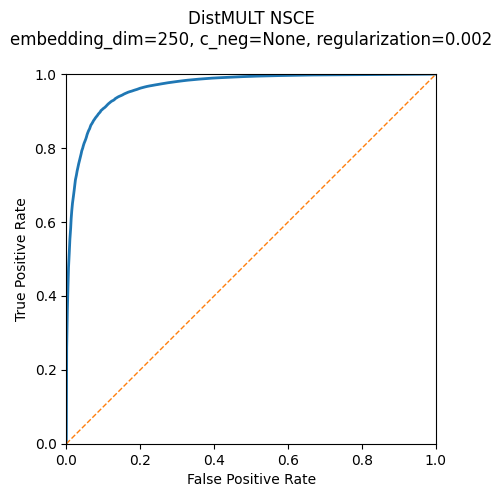

In [ ]:
import matplotlib.pyplot as plt


fig = plt.figure();
ax = fig.add_subplot();

plt.plot(SP,AC,linewidth = '2');
plt.plot([0,1],[0,1],linewidth = '1',linestyle='dashed');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
ax.set_aspect('equal', adjustable='box');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('DistMULT NSCE\nembedding_dim=250, c_neg=None, regularization=0.002\n')

plt.show()

In [ ]:
sum(np.array(AC[:-1]) * np.array([SP[i] - SP[i+1] for i in range(len(SP)-1)]))

0.9662019511242417

In [ ]:
AUROC = 0.9662019511242417